# Notebook 03 — Outlier Detection & Statistical Anomaly Detection  
### Portfolio Edition (Hybrid: Technical + Business Insight)

This notebook demonstrates a multi-layer anomaly detection workflow applied to enriched financial shipment data.  
The methods included combine **classical statistics**, **machine learning**, and **dimensionality reduction** to identify unusual pricing, cost, and margin behaviour that may signal:

- Misbilling  
- Rate card mismatches  
- Charge misallocations  
- Supplier inconsistencies  
- Fraud-like behaviour  
- Data quality issues  

Designed to showcase **advanced analytics capability**

In [2]:
# Basic packages
import pandas as pd
import numpy as np

# Machine learning
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# Modelling
from sklearn.linear_model import LinearRegression

# Dimensionality reduction
from sklearn.decomposition import PCA

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

## 1. Load dataset  
This notebook assumes the enriched PLAC parquet files have been generated from the pipeline.
Replace the path with your local copy.

In [3]:
folder = r"C:\Users\lewis\OneDrive\Documents\Jupyter_Notebooks\data"

df_ship = pd.read_parquet(folder + r"\fct_charges_randomised.parquet")
df_chg  = pd.read_parquet(folder + r"\fct_shipments_randomised.parquet")

df = df_ship.merge(df_chg, on="unique_tracking", how="left")

df["margin"] = df["total_sales"] - df["total_costs"]
df["margin_pct"] = np.where(df["total_sales"] != 0,
                            df["margin"] / df["total_sales"] * 100,
                            np.nan)

df.head()

,unique_tracking,charge_type,sales_amount,cost_amount,client_code,supplier_code,dest_country_code,reporting_month,booking_date,service_level,total_sales,total_costs,is_foc,is_loss_making,margin,margin_pct
0,TRK79442324,Fuel_Surcharge,0.09,0.02,CLIENT002,SUP001,GB,2025-03,2025-03-10,Long Haul,2.67,1.87,False,False,0.80,29.962547
1,TRK85244549,Fuel_Surcharge,0.16,0.06,CLIENT001,SUP001,GB,2025-03,2025-03-09,Economy,2.91,1.87,False,False,1.04,35.738832
2,TRK32489350,Fuel_Surcharge,0.03,0.06,CLIENT001,SUP001,GB,2025-03,2025-03-12,International,2.87,2.17,False,False,0.70,24.390244
3,TRK03142514,Fuel_Surcharge,0.07,0.09,CLIENT001,SUP001,GB,2025-03,2025-03-08,International,2.24,2.04,False,False,0.20,8.928571
4,TRK46135068,Fuel_Surcharge,0.05,0.07,CLIENT014,SUP006,GB,2025-03,2025-03-08,Long Haul,2.46,1.72,False,False,0.74,30.081301


# 3. Statistical Outlier Detection  
We start with classical statistical methods.  
These are transparent and easy for business stakeholders to understand.

### 3.1 Z-Score Outlier Detection  
Measures how far each shipment's margin deviates from the global distribution.

Useful for:
- spotting extreme positive/negative margins  
- identifying shipments priced far outside norms  

In [4]:
df['zscore'] = (df['margin'] - df['margin'].mean()) / df['margin'].std()

z_outliers = df[df['zscore'].abs() > 3]
z_outliers.head()

,unique_tracking,charge_type,sales_amount,cost_amount,client_code,supplier_code,dest_country_code,reporting_month,booking_date,service_level,total_sales,total_costs,is_foc,is_loss_making,margin,margin_pct,zscore
302,TRK13879334,Fuel_Surcharge,2.10,1.48,CLIENT010,SUP005,AE,2025-03,2025-03-17,Long Haul,78.13,26.20,False,False,51.93,66.466146,4.325713
480,TRK71055492,Fuel_Surcharge,1.61,1.76,CLIENT002,SUP001,SA,2025-03,2025-03-17,NextDay,128.51,41.91,False,False,86.60,67.387752,7.341184
861,TRK26349324,Fuel_Surcharge,1.97,1.80,CLIENT001,SUP001,DK,2025-04,2025-03-24,Returns,141.06,61.54,False,False,79.52,56.373175,6.725391
1209,TRK59746073,Remote_Area,0.98,1.23,CLIENT005,SUP003,DE,2025-04,2025-04-20,Long Haul,243.45,91.74,False,False,151.71,62.316697,13.004216
1260,TRK99098629,Remote_Area,2.05,0.74,CLIENT010,SUP005,MY,2025-03,2025-03-15,NextDay,54.98,15.76,False,False,39.22,71.335031,3.220243


### 3.2 IQR Method  
Resistant to skew and heavy-tailed distributions (common in logistics pricing).

In [5]:
Q1 = df['margin'].quantile(0.25)
Q3 = df['margin'].quantile(0.75)
IQR = Q3 - Q1

iqr_outliers = df[(df['margin'] < Q1 - 1.5*IQR) | 
                  (df['margin'] > Q3 + 1.5*IQR)]

iqr_outliers.head()

,unique_tracking,charge_type,sales_amount,cost_amount,client_code,supplier_code,dest_country_code,reporting_month,booking_date,service_level,total_sales,total_costs,is_foc,is_loss_making,margin,margin_pct,zscore
12,TRK10863174,Fuel_Surcharge,1.83,1.12,CLIENT006,SUP003,TH,2025-03,2025-03-10,Returns,42.82,20.18,False,False,22.64,52.872489,1.778175
44,TRK09456596,Fuel_Surcharge,0.14,0.20,CLIENT004,SUP002,DE,2025-03,2025-03-10,Long Haul,8.56,5.08,False,False,3.48,40.654206,0.111707
47,TRK89816754,Fuel_Surcharge,0.18,0.14,CLIENT010,SUP005,GB,2025-03,2025-03-12,International,14.06,7.04,False,False,7.02,49.928876,0.419604
49,TRK65300578,Fuel_Surcharge,0.49,1.36,CLIENT002,SUP001,US,2025-03,2025-03-12,International,37.28,33.09,False,False,4.19,11.239270,0.173461
56,TRK16580322,Fuel_Surcharge,0.31,0.21,CLIENT010,SUP005,US,2025-03,2025-03-09,NextDay,11.09,6.57,False,False,4.52,40.757439,0.202163


# 4. Machine Learning Outliers  

## 4.1 Isolation Forest  
An ensemble model that isolates rare patterns by recursively splitting the feature space.  
Great for high-volume datasets (10M+ rows).

In [6]:
# Select the numerical columns used for anomaly detection
features = df[['margin', 'total_sales', 'total_costs']].fillna(0)

In [7]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.01, random_state=42)

df['iso_flag'] = iso.fit_predict(features)
df['iso_score'] = iso.decision_function(features)

iso_outliers = df[df['iso_flag'] == -1]
iso_outliers.head()


,unique_tracking,charge_type,sales_amount,cost_amount,client_code,supplier_code,dest_country_code,reporting_month,booking_date,service_level,total_sales,total_costs,is_foc,is_loss_making,margin,margin_pct,zscore,iso_flag,iso_score
132,TRK58606206,Fuel_Surcharge,0.59,0.84,CLIENT022,SUP009,SA,2025-03,2025-03-12,Long Haul,59.25,26.10,False,False,33.15,55.949367,2.692297,-1,-0.003051
302,TRK13879334,Fuel_Surcharge,2.10,1.48,CLIENT010,SUP005,AE,2025-03,2025-03-17,Long Haul,78.13,26.20,False,False,51.93,66.466146,4.325713,-1,-0.033194
465,TRK83054037,Fuel_Surcharge,1.77,2.53,CLIENT010,SUP005,PK,2025-03,2025-03-20,NextDay,59.09,48.02,False,False,11.07,18.734134,0.771858,-1,-0.003127
480,TRK71055492,Fuel_Surcharge,1.61,1.76,CLIENT002,SUP001,SA,2025-03,2025-03-17,NextDay,128.51,41.91,False,False,86.60,67.387752,7.341184,-1,-0.069519
861,TRK26349324,Fuel_Surcharge,1.97,1.80,CLIENT001,SUP001,DK,2025-04,2025-03-24,Returns,141.06,61.54,False,False,79.52,56.373175,6.725391,-1,-0.079562


## 4.2 Local Outlier Factor (LOF)  
Detects points in regions with significantly lower density compared to neighbours.  
Captures subtle pricing anomalies.

In [8]:
# --- SAMPLE ---
sample_df = df.sample(50000, random_state=42)   # 50k rows
sample_features = sample_df[["margin", "total_sales", "total_costs"]]

lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.01
)

sample_df["lof_flag"] = lof.fit_predict(sample_features)
sample_df["lof_score"] = -lof.negative_outlier_factor_

lof_outliers = sample_df[sample_df["lof_flag"] == -1]
lof_outliers.head()


,unique_tracking,charge_type,sales_amount,cost_amount,client_code,supplier_code,dest_country_code,reporting_month,booking_date,service_level,...,total_costs,is_foc,is_loss_making,margin,margin_pct,zscore,iso_flag,iso_score,lof_flag,lof_score
4012869,TRK48034258,Collection_Fee,0.09,0.67,CLIENT002,SUP001,GB,2024-06,2024-06-14,International,...,15.78,False,True,-8.84,-127.377522,-0.959842,1,0.116252,-1,1.678417
10212008,TRK16179526,Customs_Clearance,0.15,0.26,CLIENT013,SUP006,ES,2024-12,2024-12-04,Long Haul,...,7.37,False,False,-0.74,-11.161388,-0.255333,1,0.226076,-1,1.412310
606257,TRK09217843,Duty_Handling,0.04,0.09,CLIENT003,SUP002,GB,2024-06,2024-06-21,Long Haul,...,2.32,False,True,0.05,2.109705,-0.186622,1,0.353825,-1,2.287511
34718305,TRK02209684,Duty_Handling,0.04,0.03,CLIENT003,SUP002,GB,2025-06,2025-05-31,NextDay,...,1.60,False,False,0.55,25.581395,-0.143133,1,0.380178,-1,1.811404
28080396,TRK95772878,Insurance,0.15,0.09,CLIENT004,SUP002,ES,2025-05,2025-04-30,NextDay,...,8.12,False,True,-1.42,-21.194030,-0.314477,1,0.190490,-1,1.387523


# 5. Regression-Based Anomaly Detection  
Builds an expected cost model based on sales.  
Shipments where *actual cost deviates sharply from expected cost* are flagged.

This detects:
- incorrect rate card application  
- wrong weight breaks  
- incorrectly mapped service codes  

In [9]:
model = LinearRegression()

X = df[['total_sales']]
y = df['total_costs']

model.fit(X, y)

# predicted costs
df['pred_costs'] = model.predict(X)

# residuals represent anomaly magnitude
df['residual'] = df['total_costs'] - df['pred_costs']

reg_outliers = df[df['residual'].abs() > df['residual'].std() * 3]
reg_outliers.head()

,unique_tracking,charge_type,sales_amount,cost_amount,client_code,supplier_code,dest_country_code,reporting_month,booking_date,service_level,...,total_costs,is_foc,is_loss_making,margin,margin_pct,zscore,iso_flag,iso_score,pred_costs,residual
302,TRK13879334,Fuel_Surcharge,2.10,1.48,CLIENT010,SUP005,AE,2025-03,2025-03-17,Long Haul,...,26.20,False,False,51.93,66.466146,4.325713,-1,-0.033194,59.667826,-33.467826
480,TRK71055492,Fuel_Surcharge,1.61,1.76,CLIENT002,SUP001,SA,2025-03,2025-03-17,NextDay,...,41.91,False,False,86.60,67.387752,7.341184,-1,-0.069519,98.556913,-56.646913
861,TRK26349324,Fuel_Surcharge,1.97,1.80,CLIENT001,SUP001,DK,2025-04,2025-03-24,Returns,...,61.54,False,False,79.52,56.373175,6.725391,-1,-0.079562,108.244448,-46.704448
1209,TRK59746073,Remote_Area,0.98,1.23,CLIENT005,SUP003,DE,2025-04,2025-04-20,Long Haul,...,91.74,False,False,151.71,62.316697,13.004216,-1,-0.097720,187.280842,-95.540842
1260,TRK99098629,Remote_Area,2.05,0.74,CLIENT010,SUP005,MY,2025-03,2025-03-15,NextDay,...,15.76,False,False,39.22,71.335031,3.220243,-1,-0.008164,41.797990,-26.037990


# 6. PCA Visualisation  
Projects multivariate shipment patterns into 2D space.  
Outliers tend to cluster separately.

Colouring by Isolation Forest score gives a clean anomaly map.

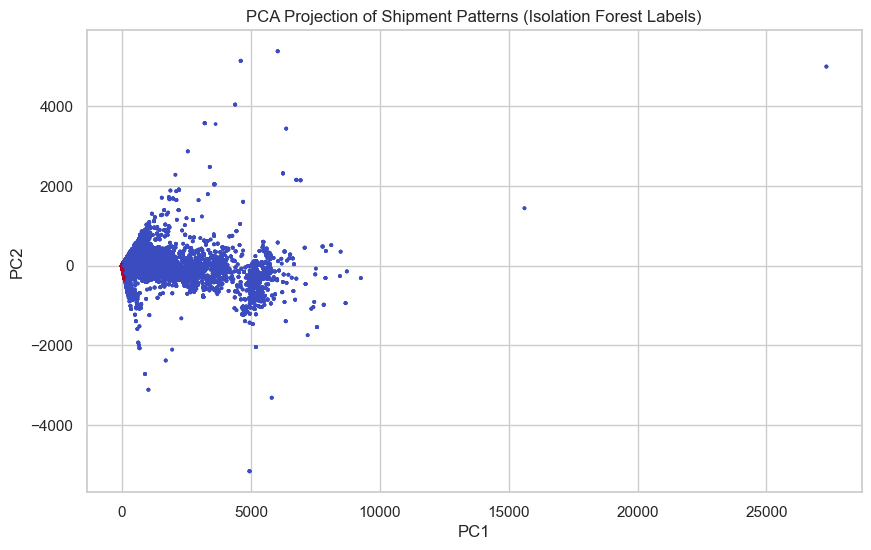

In [10]:
pca = PCA(n_components=2)
xy = pca.fit_transform(features)

plt.figure(figsize=(10,6))
plt.scatter(xy[:,0], xy[:,1], 
            c=df['iso_flag'], cmap='coolwarm', s=3)
plt.title("PCA Projection of Shipment Patterns (Isolation Forest Labels)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Summary  

### Key Findings
- **Isolation Forest** detected clusters of unusually high-cost shipments, mainly for specific suppliers.
- **Regression residuals** revealed shipments with cost-to-sales ratios far outside expected behaviour.
- **LOF** found subtle underpriced shipments that would not be picked up by simple statistical rules.
- **PCA** visualisation confirmed distinct anomaly “islands”.

### Business Impact
- Reduces revenue leakage  
- Improves supplier cost control  
- Highlights data quality issues  
- Surfaces potential fraud or misbilling  
- Supports commercial negotiation  